# Generalized Language Models

Good reference: https://lilianweng.github.io/lil-log/2019/01/31/generalized-language-models.html

Slides: https://docs.google.com/presentation/d/1xhOocjNJ-6YU_jXPJb_Yi0Vloen65QCyM51S7-Dadfk/edit?usp=sharing

Hands On LLMs (book) GitHub: https://github.com/HandsOnLLM/Hands-On-Large-Language-Models

In [ ]:
# # Use pytorch kernel and install TF, as needed
# !pip install --upgrade torch
# !pip install --upgrade tensorflow

## Classification with Embeddings and BERT

We can use many approaches as seen earlier. A good summary of classification approaches in various NLP libraries is discussed here: https://towardsdatascience.com/which-is-the-best-nlp-d7965c71ec5f


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


In [ ]:
%%capture
%pylab inline
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

## Sequence of Classification Approaches

Various forms of input are possible:

1. Use a single vector from the TDM for classification of each document. Easy to construct, but lacking context. Input size is fixed. Vocab size is large.

2. Use a single TFIDF vector. Same as TDM vectors.

3. Word2Vec. Convert each word in the document into a fixed length vector. Combine vectors into a matrix for the document and this is the input into the classifier. Requires a package like gensim to make the word embeddings, some compute effort required. Fixed input size, 100-300, not huge as in TDM, TFIDF.

4. Doc2Vec. Each document is converted into a vector, which is input into the classifier (also needs gensim). Input size is fixed.

5. MPN. Use a standard NN to create word embeddings. Only takes a few tokens and truncates the document/sentence. Enlarging the window results in an explosion in parameters. No context.

6. RNN. Keeps track of word sequences and generates one embedding for a sequence of words. Can take any sequence length. Same weight matrix for all inputs. Keeps context. But slow, loses track of words further back in the sequence, so may be giving greater weight to words at the end. Vanishing gradients.

7. LSTMs. Same as RNN, but tries to fix the problem of vanishing gradients for RNNs. Goes in only one direction, so full context is missed. For example, in translation, words before and after current word matter.

8. CNN. Faster than RNNs as they do not have to wait to process tokens sequentially. Parallelization possible. Not fixed input, so padding is required.

9. Attention. These are bidirectional, so work better for all tasks as they have greater context. Also computationally better than LSTMs. No fixed input, limited maximum sequence length.

This historical sequence is also presented in these slides from NVIDIA:
- [Machine Learning with NLP](https://drive.google.com/file/d/1sVFHBrAg0Tvm9NzG9TpgX336IpHdM-_6/view?usp=sharing)
- [Self-supervision, BERT, and Beyond](https://drive.google.com/file/d/1_ir_0FUg53RGaGDMTpAeyMSwiFIBgoR7/view?usp=sharing)

## Read in the data

Datasets:
1. Reddit news with Dow sign, https://www.kaggle.com/aaron7sun/stocknews
2. Movie reviews, https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
3. Financial Phrase Bank, https://www.researchgate.net/publication/251231364_FinancialPhraseBank-v10  

In [ ]:
# Read data
# df = pd.read_csv('NLP_data/Combined_News_DJIA.csv')  # Reddit News vs Dow data
# df = pd.read_csv('NLP_data/movie_review.csv', parse_dates=True, index_col=0)  # Movie Reviews data
df = pd.read_csv('NLP_data/Sentences_AllAgree.txt', sep=".@", header=None, encoding = "ISO-8859-1")  # Finbert data
print(df.shape)
# df.columns = ["Label","Text"]  # for movie reviews
df.columns = ["Text","Label"]
df.head()

<ipython-input-4-4963ab198381>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('NLP_data/Sentences_AllAgree.txt', sep=".@", header=None, encoding = "ISO-8859-1")  # Finbert data


(2264, 2)


Text     Label
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive

In [ ]:
# # Remove all the b-prefixes (for DJIA dataset)
# for k in range(1,26):
#   colname = "Top"+str(k)
#   df[colname] = df[colname].str[2:]

# # Prepare the data
# columns = ['Top' + str(i+1) for i in range(25)]
# df['Text'] = df[columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)
# df = df[['Label', 'Text']]
# df.head()

<Axes: xlabel='Label', ylabel='count'>

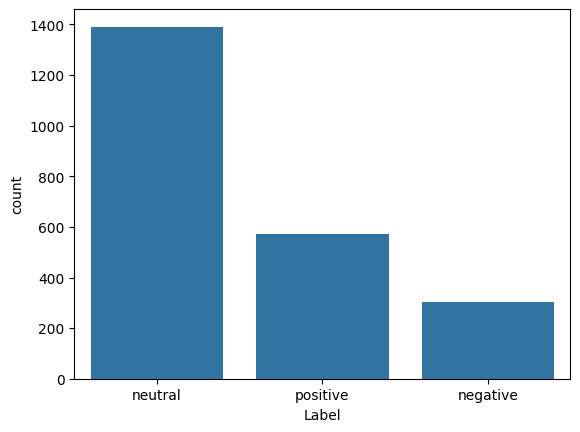

In [ ]:
# Plot class distribution
import seaborn as sns
sns.countplot(x='Label', data=df)

## Now install raw text tools

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
# See Transformers from Hugging Face: https://huggingface.co/transformers/
# Simple Transformers: https://github.com/ThilinaRajapakse/simpletransformers

!pip install gensim
# !pip install transformers

In [ ]:
import json
from sklearn import feature_extraction, feature_selection, metrics
from sklearn import model_selection, naive_bayes, pipeline, manifold, preprocessing
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import transformers

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Use texthero as an alternative text cleaner, instead of the code below
import re # regex

def removeNumbersStr(s):
    for c in range(10):
        n = str(c)
        s = s.replace(n," ")
    return s

def cleanText(text, stem=False, lemm=True, stop=True):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())  # remove stuff
    text = removeNumbersStr(text)
    text = text.split()  # tokenize
    if stop is not None:  # remove stopwords
        text = [word for word in text if word not in stopwords]
    if stem == True:  # stemming
        ps = nltk.stem.porter.PorterStemmer()
        text = [ps.stem(word) for word in text]
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [ ]:
df["cleanTxt"] = [cleanText(df.Text[j]) for j in range(len(df.Label))]
print(df.shape)
df.head()

(2264, 3)


Text     Label  \
0  According to Gran , the company has no plans t...   neutral   
1  For the last quarter of 2010 , Componenta 's n...  positive   
2  In the third quarter of 2010 , net sales incre...  positive   
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive   
4  Operating profit totalled EUR 21.1 mn , up fro...  positive   

                                            cleanTxt  
0  according gran company plan move production ru...  
1  last quarter componenta net sale doubled eur e...  
2  third quarter net sale increased eur mn operat...  
3  operating profit rose eur mn eur mn correspond...  
4  operating profit totalled eur mn eur mn repres...

In [ ]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.2)
y_train = df_train["Label"].values
y_test = df_test["Label"].values

In [ ]:
# Choose BOW or TFIDF in NLTK
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))  # BOW
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # TFIDF

In [ ]:
corpus = df_train["cleanTxt"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
X_train

<1811x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 29631 stored elements in Compressed Sparse Row format>

In [ ]:
vocab = vectorizer.vocabulary_   # is a dict
list(vocab.keys())[:30]

['finnish',
 'silicon',
 'wafer',
 'technology',
 'company',
 'okmetic',
 'oyj',
 'omx',
 'helsinki',
 'okm',
 'said',
 'wednesday',
 'september',
 'invest',
 'eur',
 'business',
 'finnish silicon',
 'silicon wafer',
 'wafer technology',
 'technology company',
 'company okmetic',
 'okmetic oyj',
 'oyj omx',
 'omx helsinki',
 'helsinki okm',
 'wednesday september',
 'invest eur',
 'eur sensor',
 'real',
 'estate']

In [ ]:
X_train.shape

(1811, 10000)

## Visualize the DTM

Text(158.22222222222223, 0.5, 'Documents')

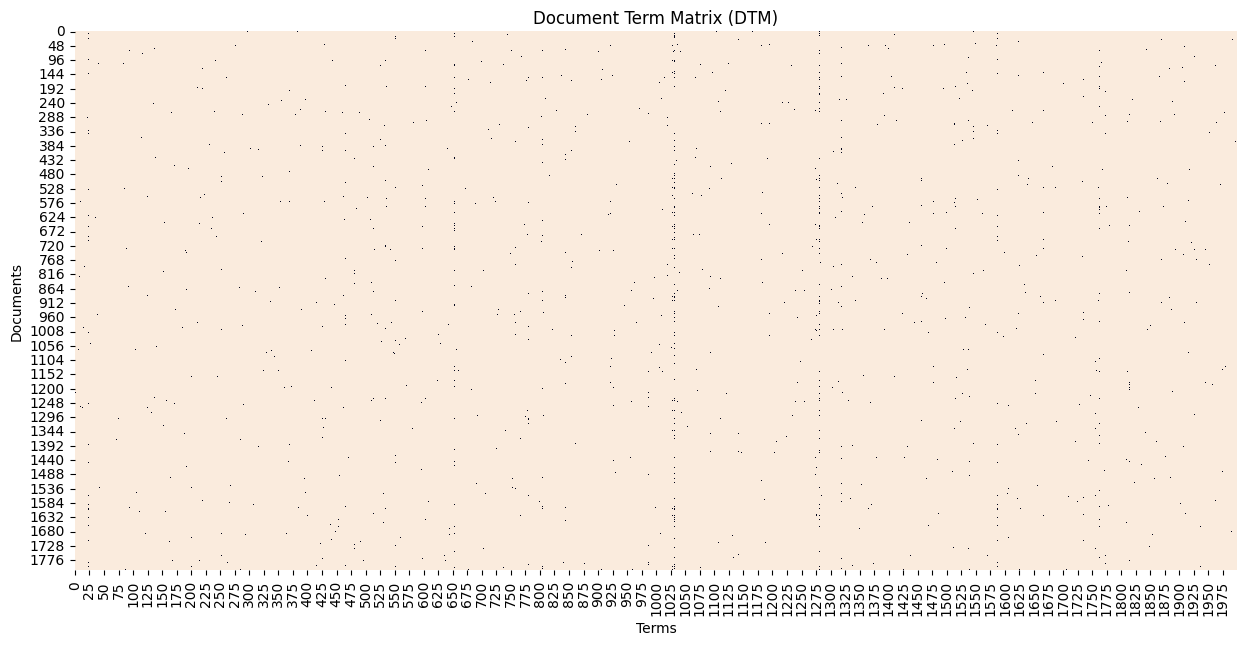

In [ ]:
figure(figsize=(15,7))
sns.heatmap(X_train.todense() [:,np.random.randint(0,X_train.shape[1],2000)]==0,
            vmin=0, vmax=1, cbar=False).set_title('Document Term Matrix (DTM)')
xlabel('Terms'); ylabel('Documents')

## Reduce the dimension of the vocabulary

In [ ]:
# Feature reduction using feature selection in sklearn
# This can also be done using TextHero
y = df_train["Label"]
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.75
df_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    df_features = pd.concat([df_features, pd.DataFrame({"feature":X_names, "score":1-p, "y":cat})])
    df_features = df_features.sort_values(["y","score"],ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()
print(type(X_names)); print(X_names[:10])
print("# features =",len(X_names))

<class 'list'>
['decreased', 'decreased eur', 'fell', 'eur mn', 'mn', 'operating loss', 'compared profit', 'fell eur', 'profit fell', 'eur']
# features = 1302


In [ ]:
# !conda install -c conda-forge xgboost -y

## TFIDF Transform Classification

In [ ]:
# Define Vectorizer
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
vocab = vectorizer.vocabulary_
print("Check vocab length:", len(vocab))

tmp = zeros(X_train.shape[0])
for j in range(len(tmp)):
    if y_train[j]=='negative':
        tmp[j] = 1
    elif y_train[j]=='positive':
        tmp[j] = 2
y_train = tmp

# Define Classifier
import xgboost as xgb
# classifier = xgb.XGBClassifier(objective="binary:logistic") # for 2 classes
classifier = xgb.XGBClassifier(objective="multi:softmax") # for multiclass

Check vocab length: 1302


In [ ]:
# Pipeline using sklearn
model = pipeline.Pipeline([("vectorizer", vectorizer),
                           ("classifier", classifier)])

In [ ]:
model["classifier"].fit(X_train, y_train)
X_test = df_test["cleanTxt"].values

# Accessing the classifier directly when making prediction
predicted = model["classifier"].predict(vectorizer.transform(X_test))  # Use transform here
predicted_prob = model["classifier"].predict_proba(vectorizer.transform(X_test))  # Use transform here


In [ ]:
tmp = zeros(X_test.shape[0])
for j in range(len(tmp)):
    if y_test[j]=='negative':
        tmp[j] = 1
    elif y_test[j]=='positive':
        tmp[j] = 2
y_test = tmp

accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])  # only for binary classification
print("Accuracy:", round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
cm = metrics.confusion_matrix(y_test, predicted)
print(cm)

Accuracy: 0.86
Detail:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       273
         1.0       0.80      0.64      0.71        58
         2.0       0.83      0.73      0.78       122

    accuracy                           0.86       453
   macro avg       0.84      0.78      0.80       453
weighted avg       0.85      0.86      0.85       453

[[262   2   9]
 [ 12  37   9]
 [ 26   7  89]]


## Using Embeddings

Ideally, we want an embedding model which gives us the smallest embedding vector and works great for the task. The smaller the embedding size, the lesser the compute required for training as well as inference.

Instead of TFIDF representations of text, we can use embeddings based on Word2Vec, Doc2Vec, etc. Much of these approaches have been superceded now by Transformer generated embeddings in the class of BERT models.  

Slides: https://docs.google.com/presentation/d/1xhOocjNJ-6YU_jXPJb_Yi0Vloen65QCyM51S7-Dadfk/edit?usp=sharing

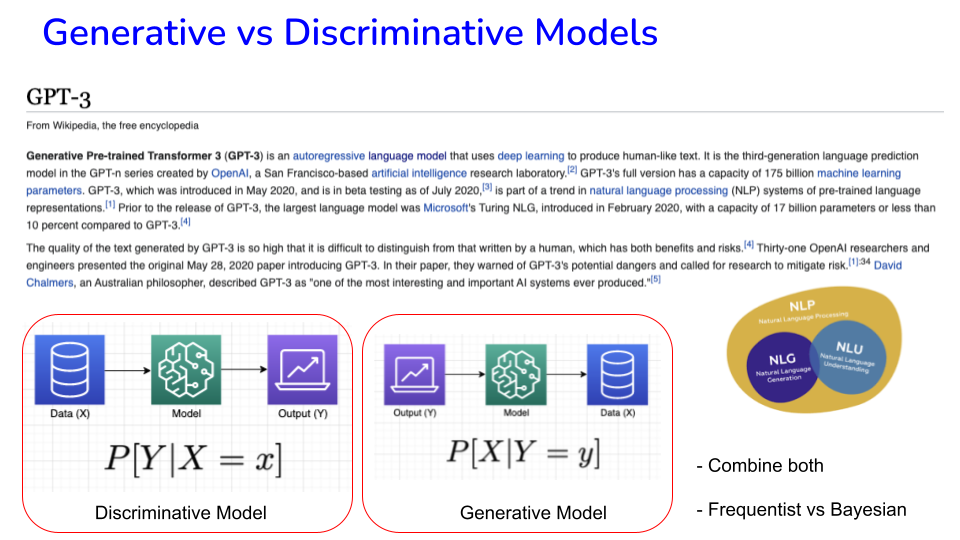

In [ ]:
Image("NLP_images/BERT (0).png", width=900)

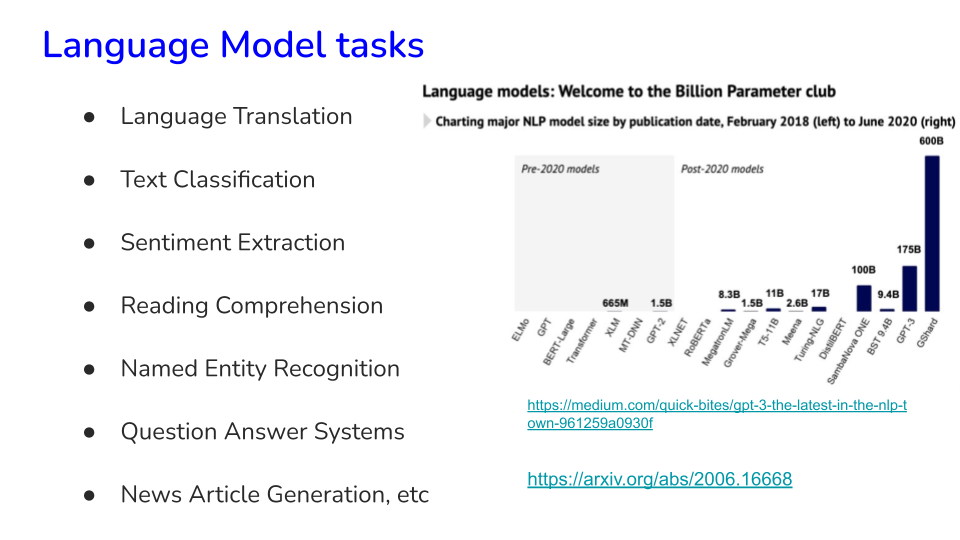

In [ ]:
Image("NLP_images/BERT (1).png", width=900)

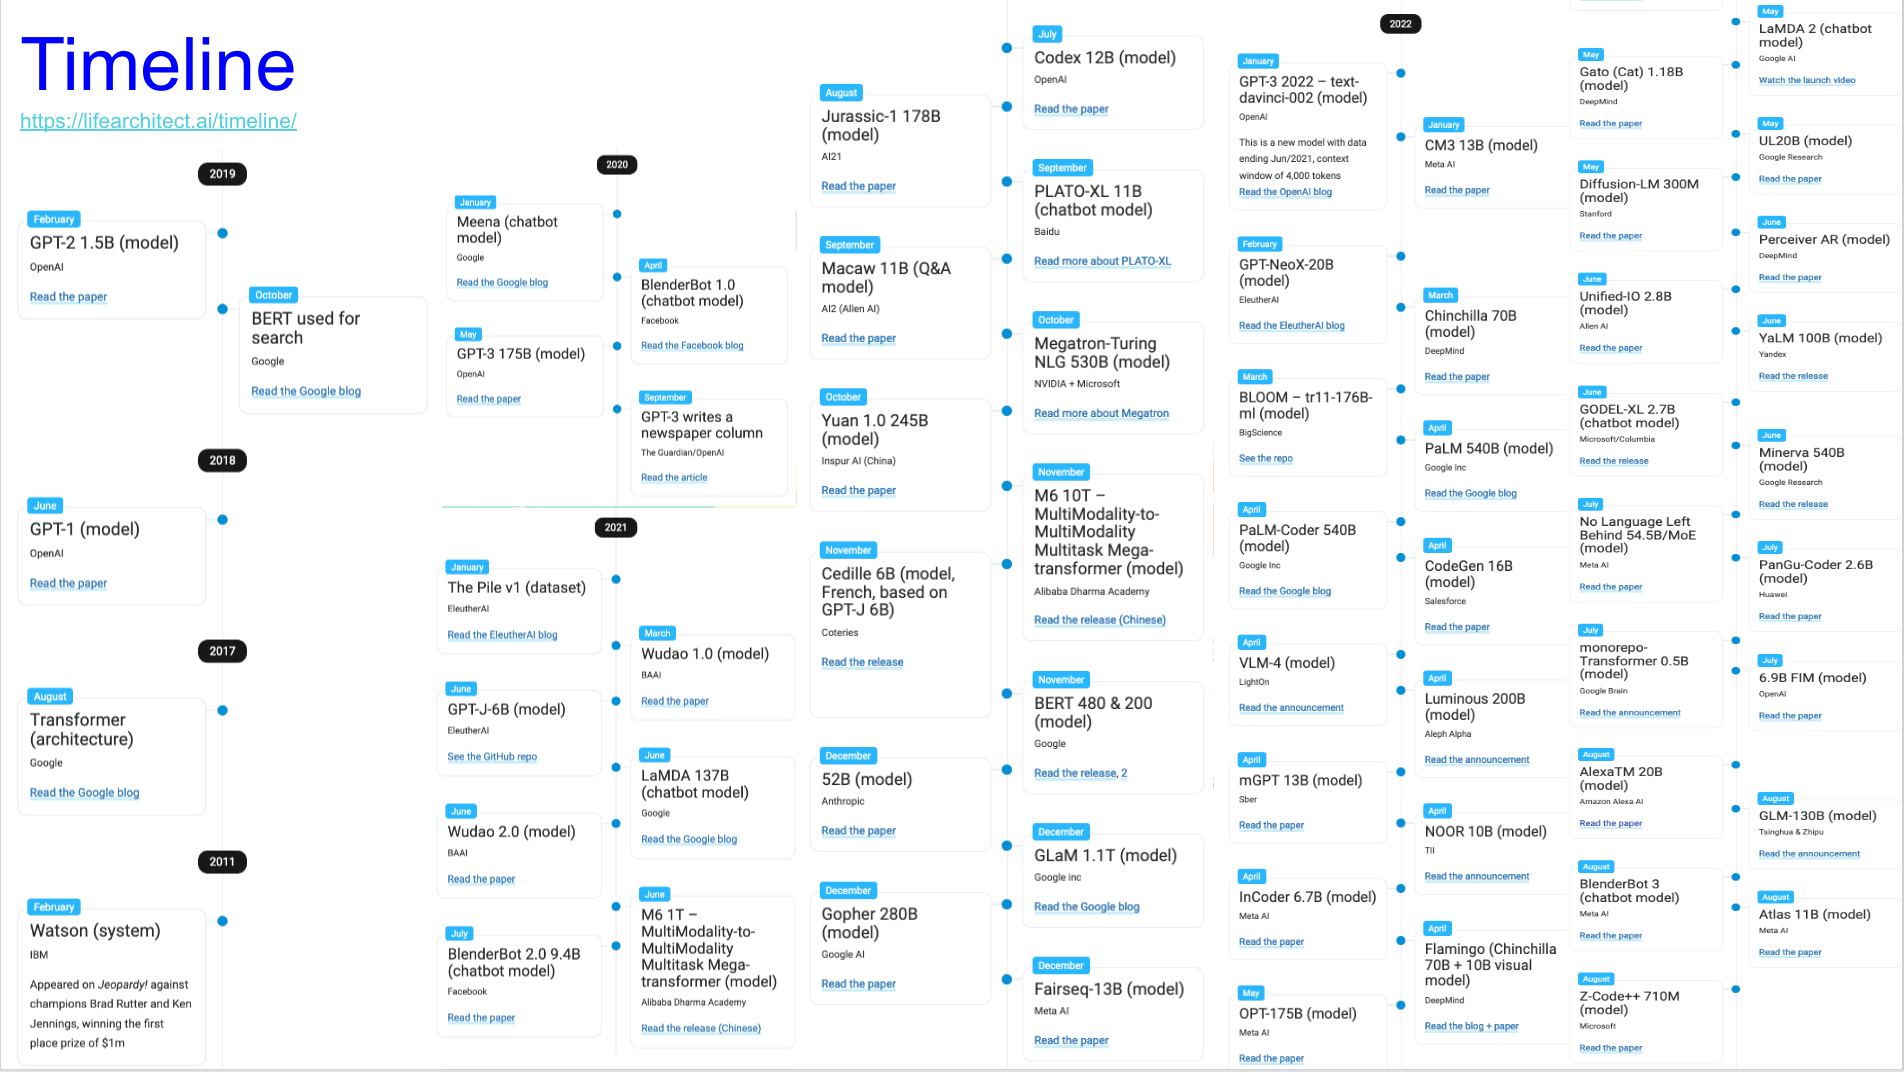

In [ ]:
Image("NLP_images/models_timeline.png", width=900)

https://lifearchitect.ai/timeline/

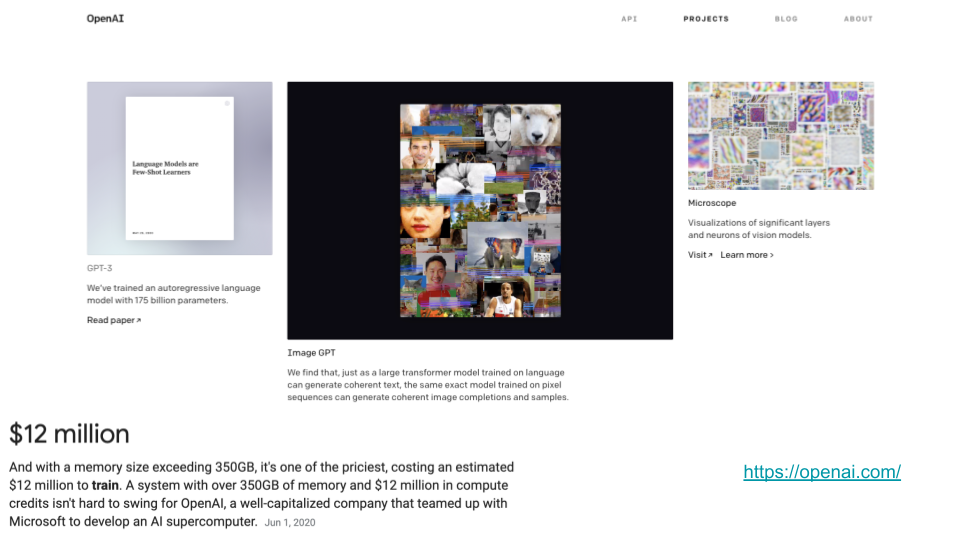

In [ ]:
Image("NLP_images/BERT (2).png", width=900)

## Transformers

Read this amazing short [book](https://drive.google.com/file/d/1LrzHTZoXP-PQ2Gzv1IOd4wJOfhtkKkzW/view?usp=sharing) for a complete introduction to transformers.

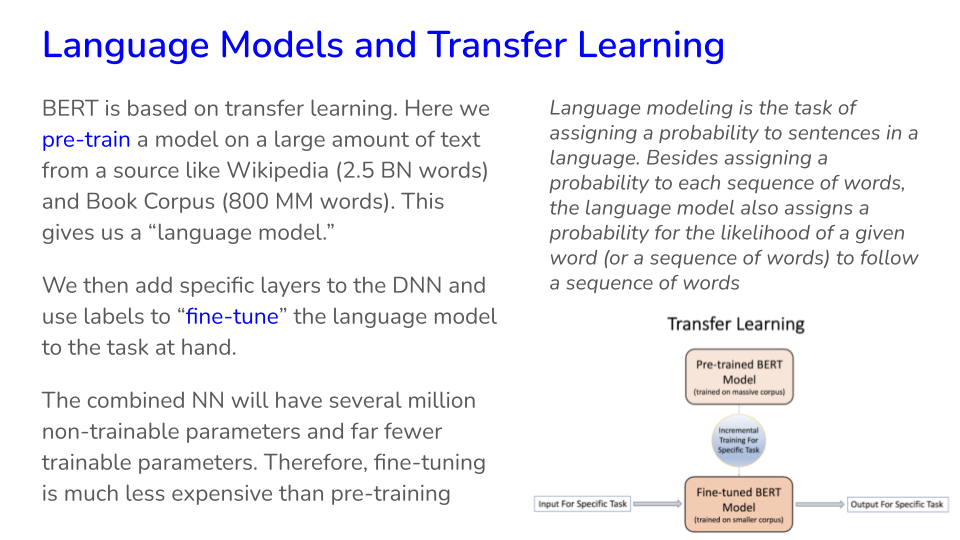

In [ ]:
Image("NLP_images/BERT (3).png", width=900)

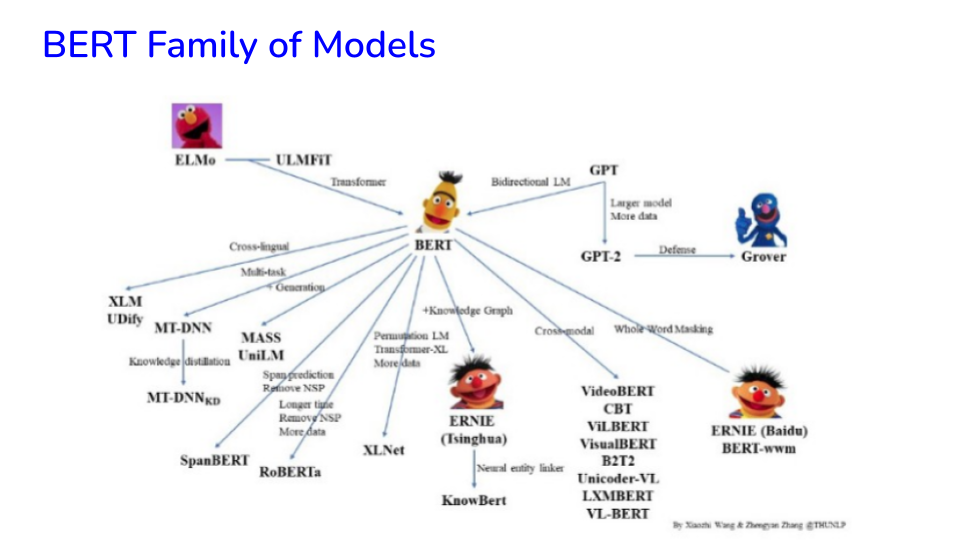

In [ ]:
Image("NLP_images/BERT (4).png", width=900)

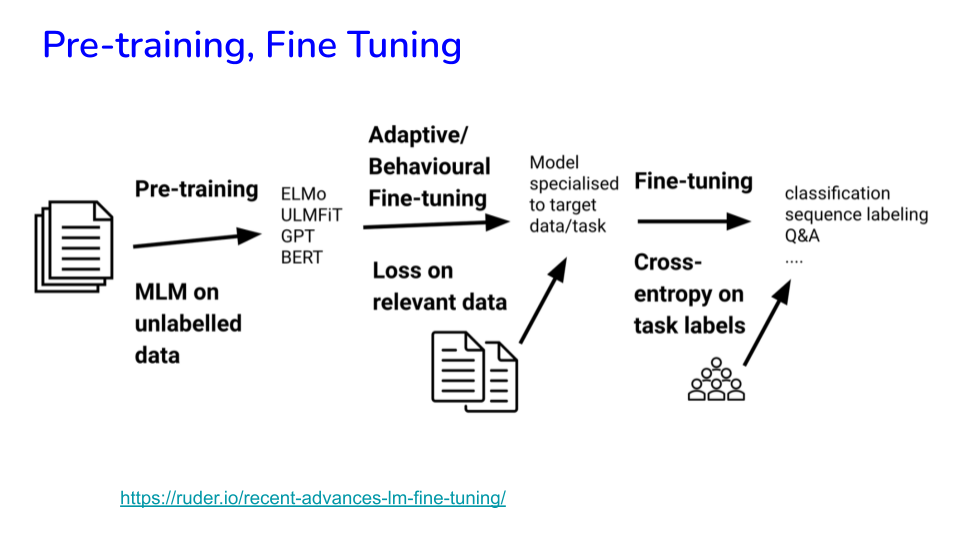

In [ ]:
Image("NLP_images/BERT (5).png", width=900)

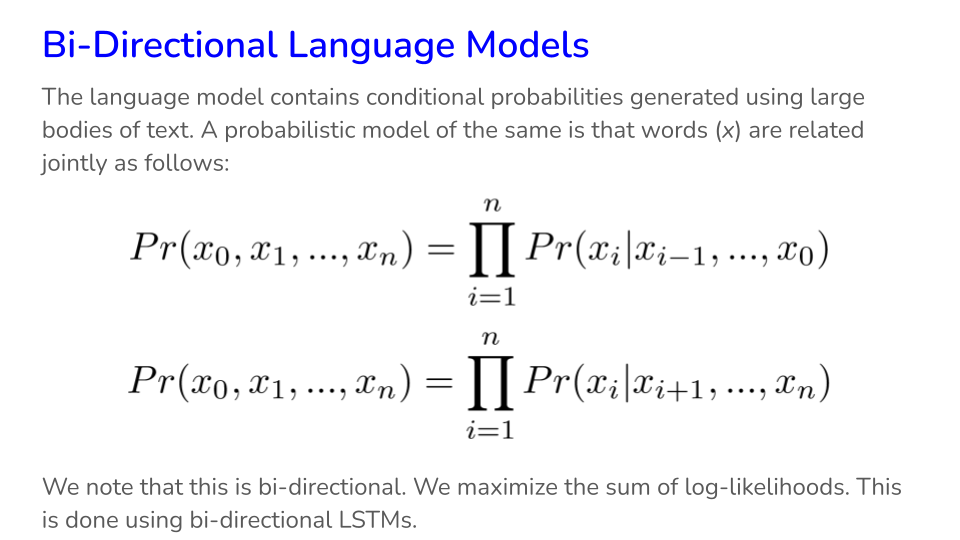

In [ ]:
Image("NLP_images/BERT (6).png", width=900)

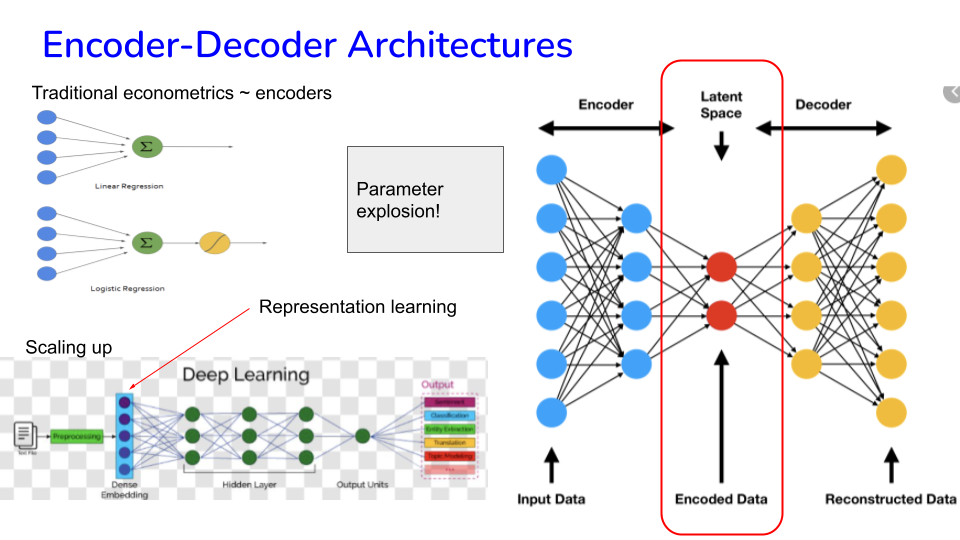

In [ ]:
Image("NLP_images/BERT (7).png", width=900)

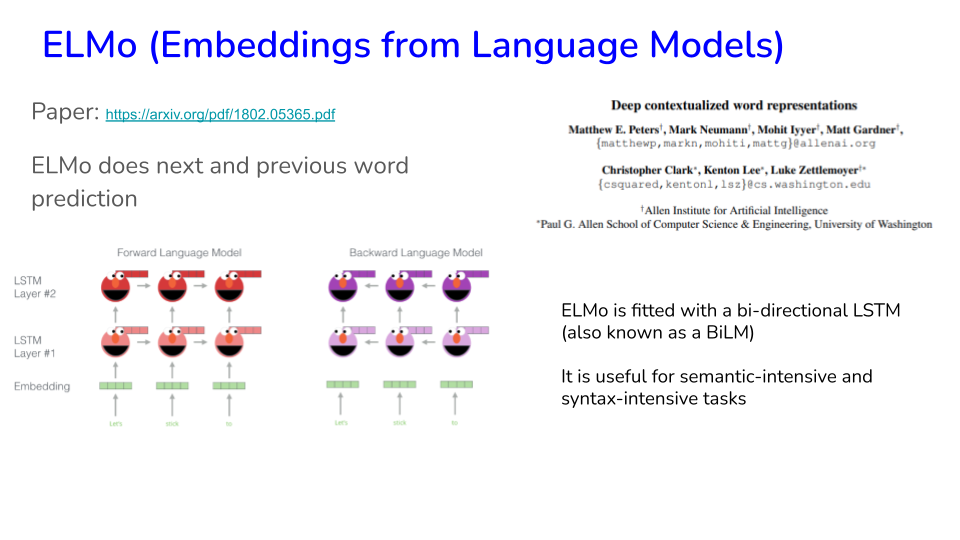

In [ ]:
Image("NLP_images/BERT (8).png", width=900)

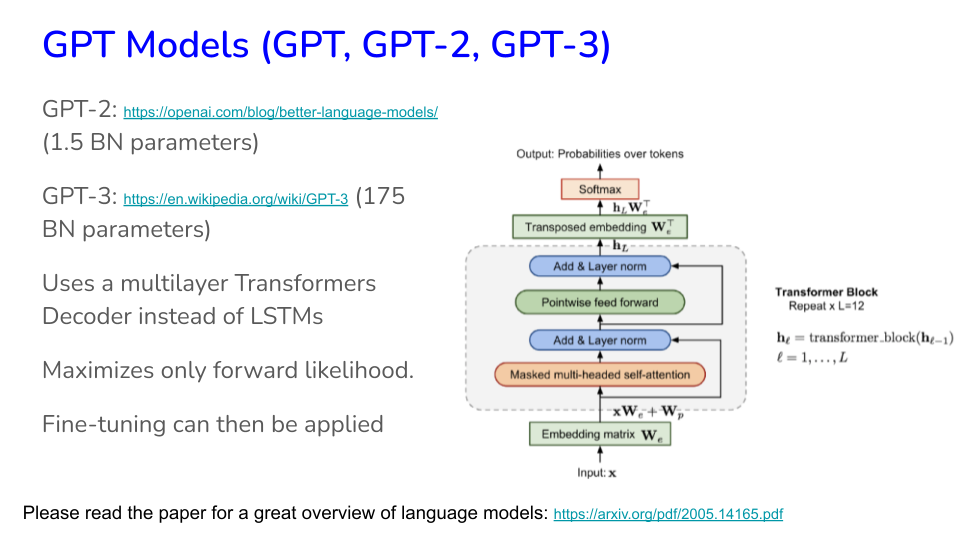

In [ ]:
Image("NLP_images/BERT (9).png", width=900)

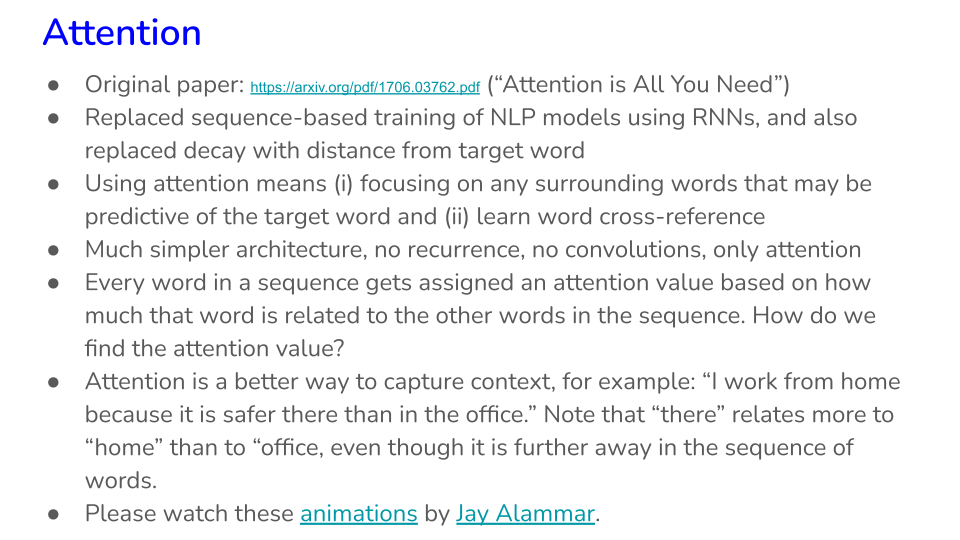

In [ ]:
Image("NLP_images/BERT (10).png", width=900)

There is some controversy about when the term "attention" first entered the literature, going way back to the 1990s. For a full and very balanced discussion, see: https://www.turingpost.com/p/attention

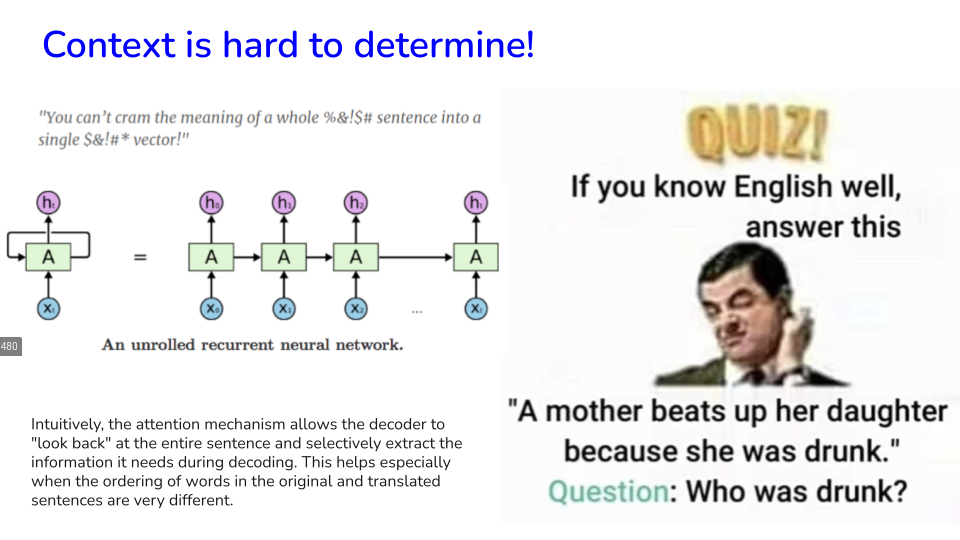

In [ ]:
Image("NLP_images/BERT (11).png", width=900)

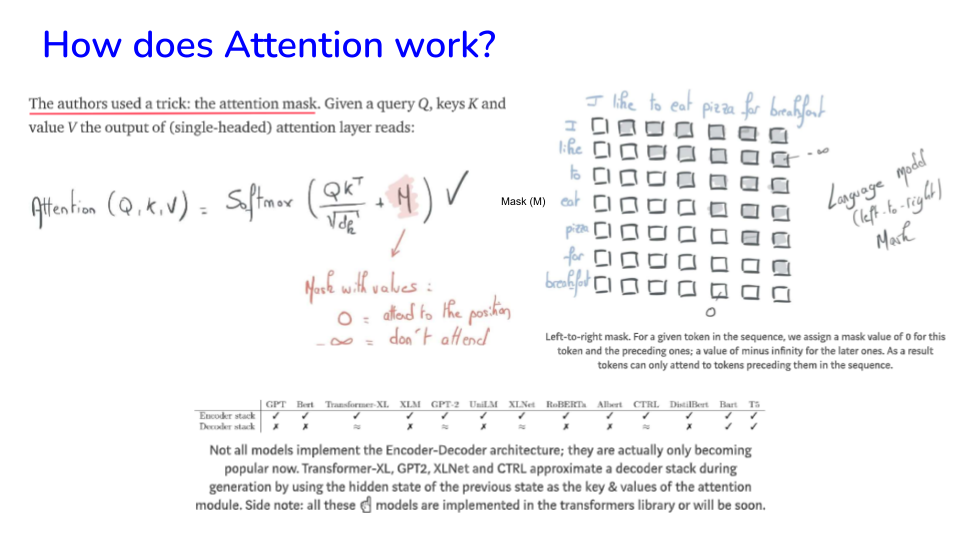

In [ ]:
Image("NLP_images/BERT (12).png", width=900)

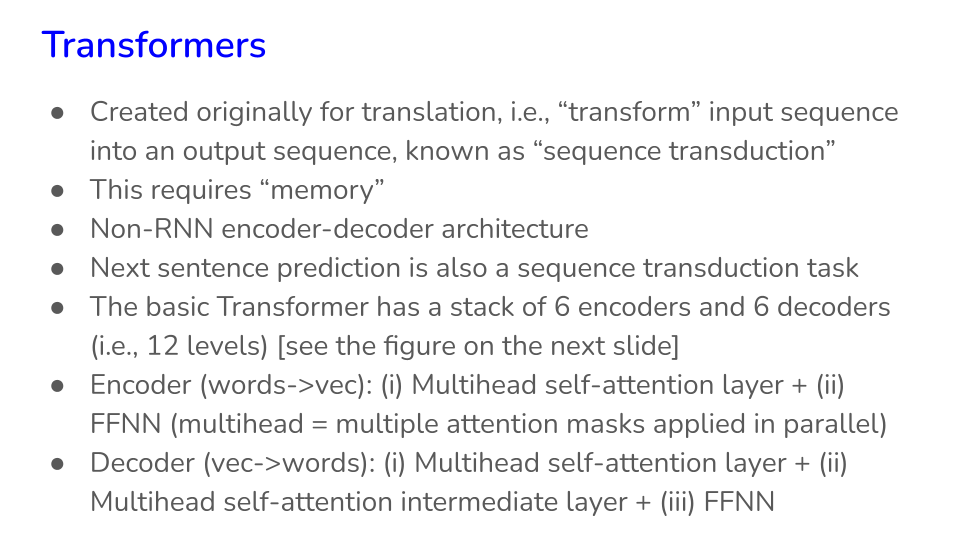

In [ ]:
Image("NLP_images/BERT (13).png", width=900)

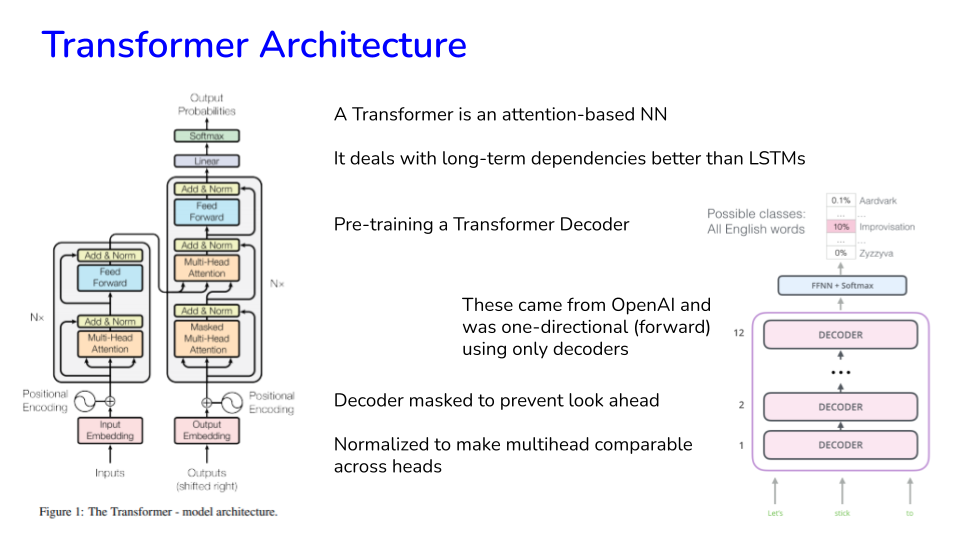

In [ ]:
Image("NLP_images/BERT (14).png", width=900)

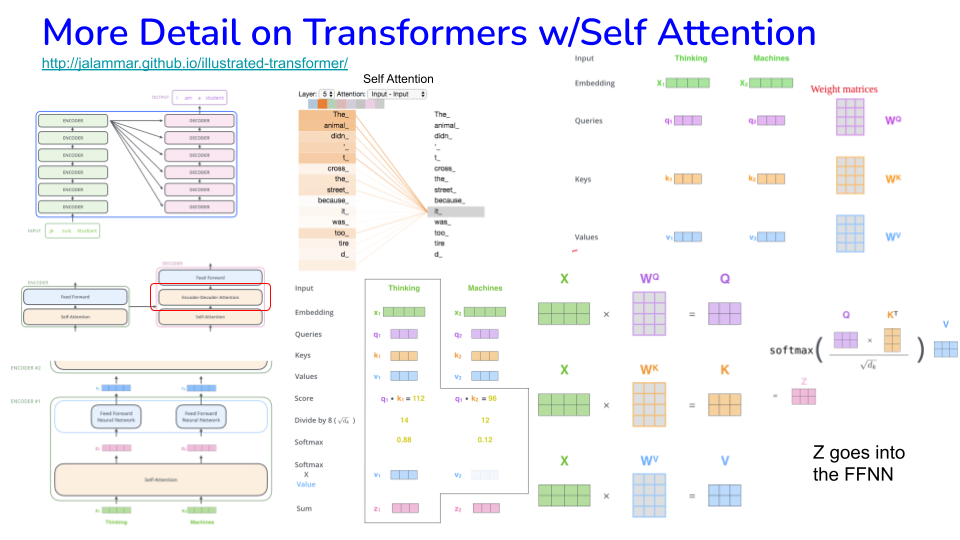

In [ ]:
Image("NLP_images/BERT (15).png", width=900)

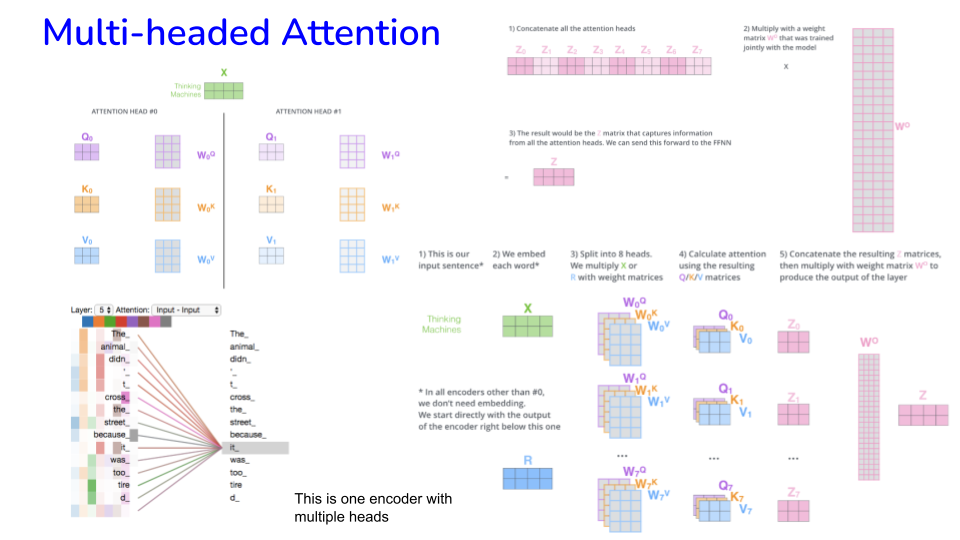

In [ ]:
Image("NLP_images/BERT (16).png", width=900)

See the [BertViz](https://github.com/jessevig/bertviz) library for visualizing attention.

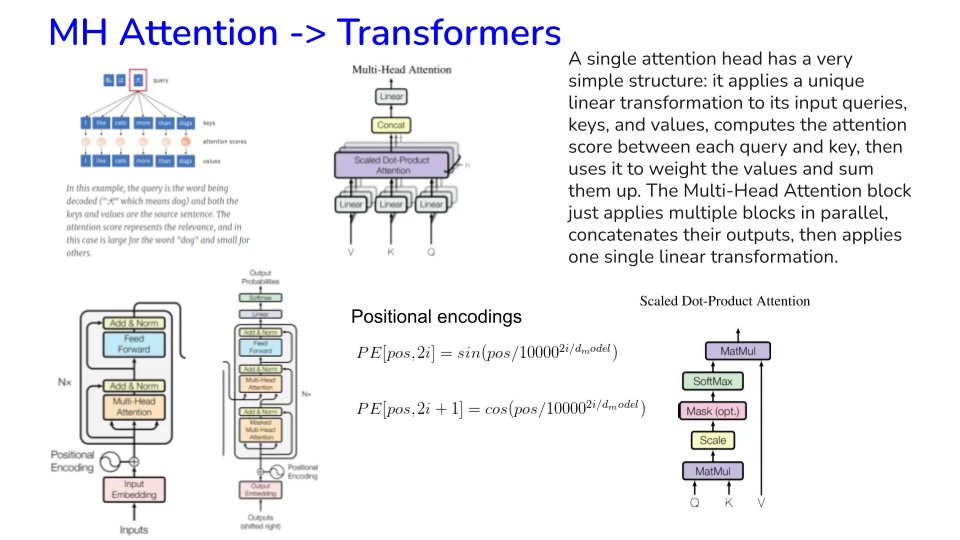

In [ ]:
Image("NLP_images/BERT (17).png", width=900)

## Transformers - Toy Example

See also Layer Normalization: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

In [ ]:
# Code to exemplify transformers
# 2 tokens, embedding dimension of 4

# Embedding matrix
x = rand(2,4)
print(f"Input Embeddings:\n {x}")

# Set up weight matrices for query (Q), key (K), and value (V) vectors
wQ = rand(4,3)
wK = rand(4,3)
wV = rand(4,3)

# Generate the queries, keys, and value vectors
q = x.dot(wQ)
k = x.dot(wK)
v = x.dot(wV)

print(f"Query:\n {q}")
print(f"Key:\n {k}")
print(f"Value:\n {v}")

# Self attention for each word
score = q.dot(k.T)
print(f"Score:\n {score}") # each row is self attention for a word

# Divide by Sqrt of query dimension
sqrt_dk = sqrt(len(q[0]))
score = score/sqrt_dk
print(f"Sqrt dk: {sqrt_dk}\nRevised score:\n {score}")

# Softmax
softmax = np.exp(score) / np.sum(np.exp(score), axis=1, keepdims=True)
print(f"Softmax:\n {softmax}") # This gives the self-attention values

# z = Softmax x value
z = softmax.dot(v)
print(f"Z:\n {z}")

Input Embeddings:
 [[0.45075562 0.74229357 0.04634493 0.78033487]
 [0.18692271 0.26294036 0.05349312 0.95006966]]
Query:
 [[1.15087916 0.86495359 1.37903087]
 [0.92269736 0.45545144 1.14133996]]
Key:
 [[0.47421934 1.66448924 1.20878598]
 [0.51401198 1.21725289 0.58093293]]
Value:
 [[0.81678006 0.74316613 1.45072069]
 [0.76519141 0.28108055 1.05849747]]
Score:
 [[3.65242828 2.44555737]
 [2.5752907  1.69171904]]
Sqrt dk: 1.7320508075688772
Revised score:
 [[2.10873045 1.4119432 ]
 [1.48684478 0.97671444]]
Softmax:
 [[0.66747508 0.33252492]
 [0.62483703 0.37516297]]
Z:
 [[0.79962555 0.58951116 1.3202967 ]
 [0.79742591 0.56980873 1.30357306]]


In [ ]:
# Multiheads for Attention
# Suppose we have 6 of these Attention results and we put them side by side
# Then we get a matrix of size 2 x 24, lets create a dummy one here:
z = rand(2,24)

# We want to bring this down to a matrix of 2 x 4 in size
# Which means we need to multiply it by a matrix of dimension 24 x 4
wO = rand(24,4)
z = z.dot(wO)
print(f"Output:\n {z}") # Each row to be fed into the separate FFNNs to complete the encoder

Output:
 [[6.95156345 7.09487513 5.76309593 6.17848586]
 [5.70568299 6.60749273 5.9616572  5.50708616]]


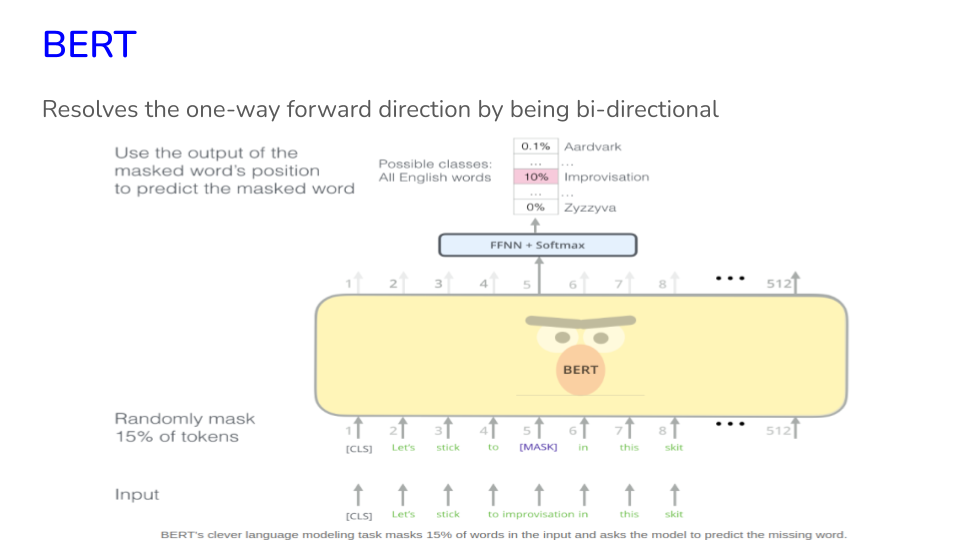

In [ ]:
Image("NLP_images/BERT (18).png", width=900)

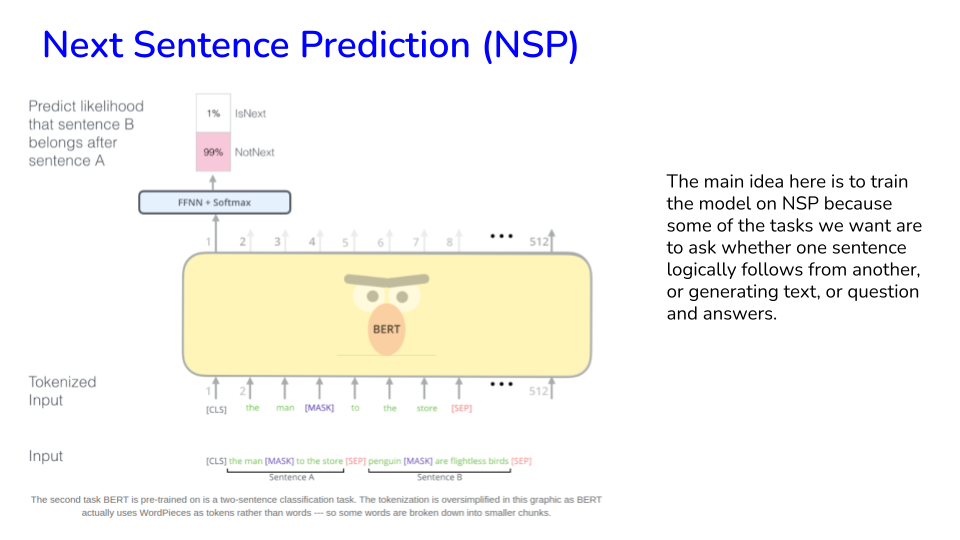

In [ ]:
Image("NLP_images/BERT (19).png", width=900)

Both schemes shown above are examples of "**Self-supervised Learning**".

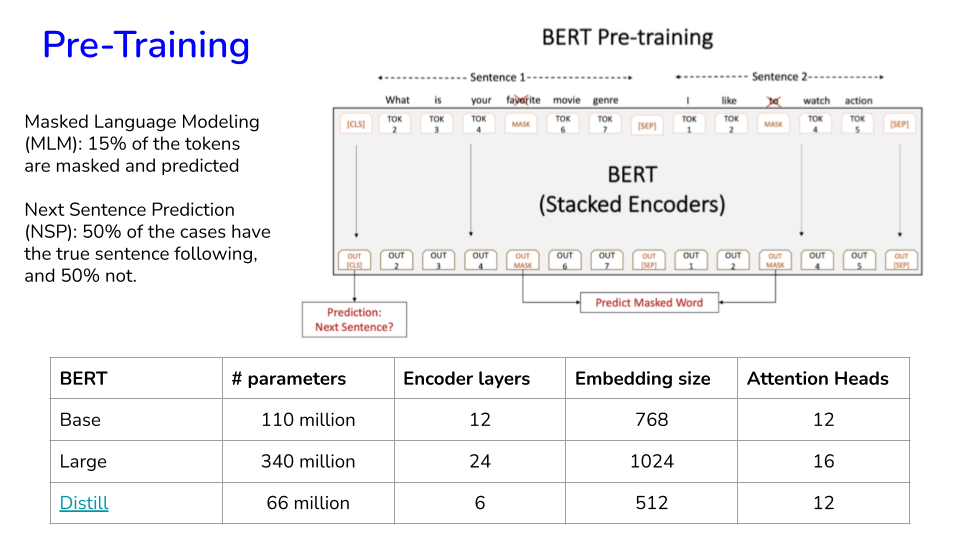

In [ ]:
Image("NLP_images/BERT (20).png", width=900)

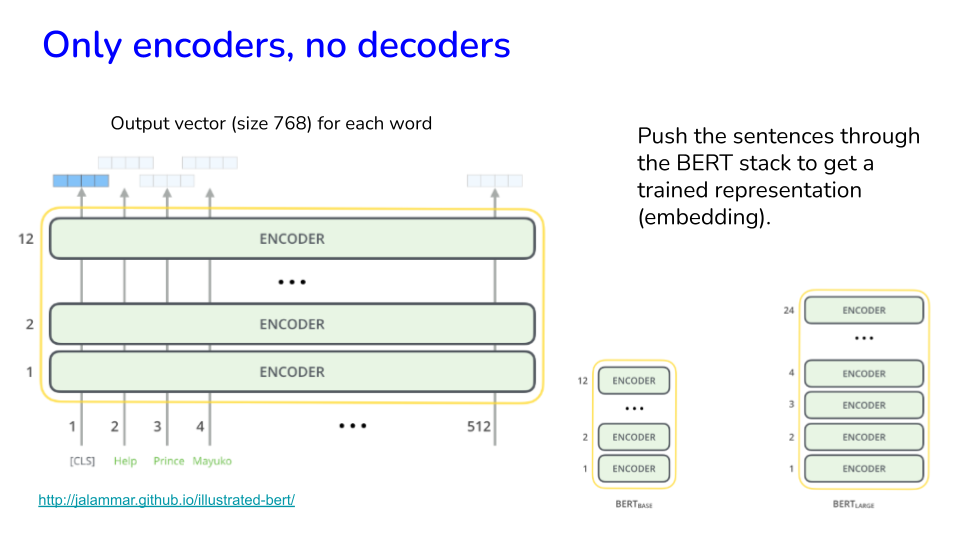

In [ ]:
Image("NLP_images/BERT (21).png", width=900)

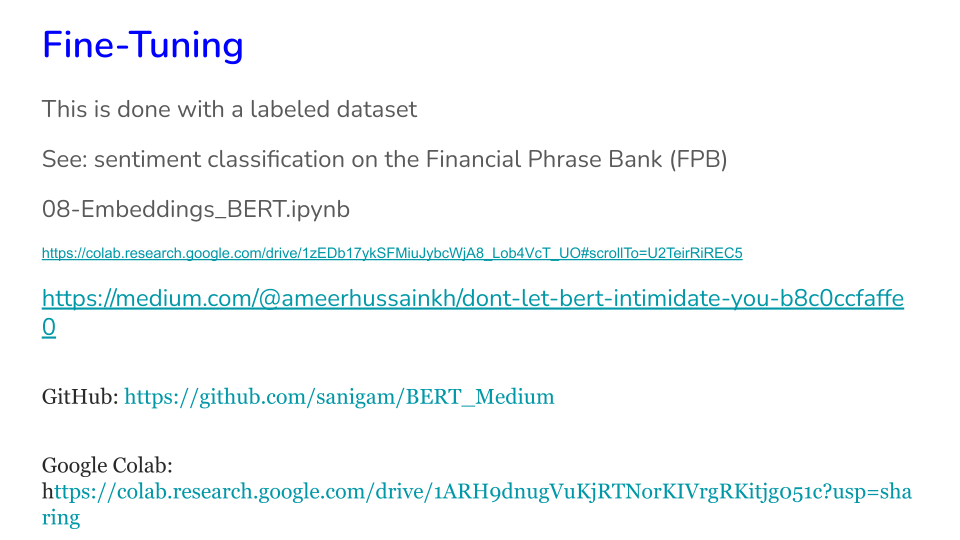

In [ ]:
Image("NLP_images/BERT (22).png", width=900)

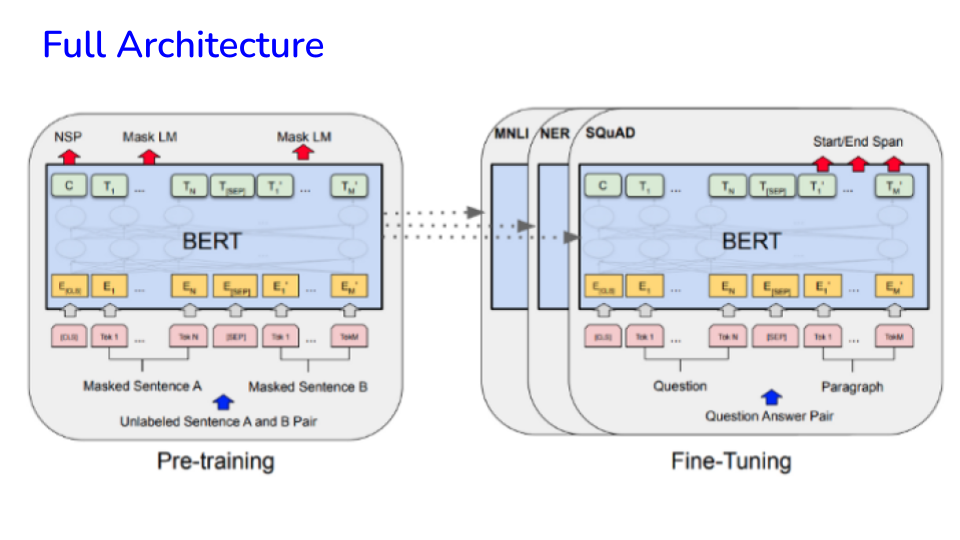

In [ ]:
Image("NLP_images/BERT (23).png", width=900)

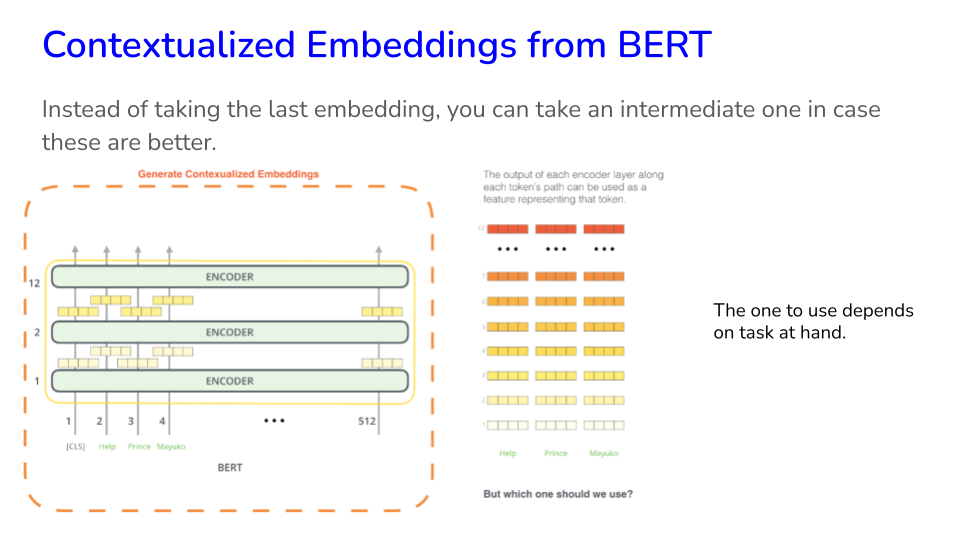

In [ ]:
Image("NLP_images/BERT (24).png", width=900)

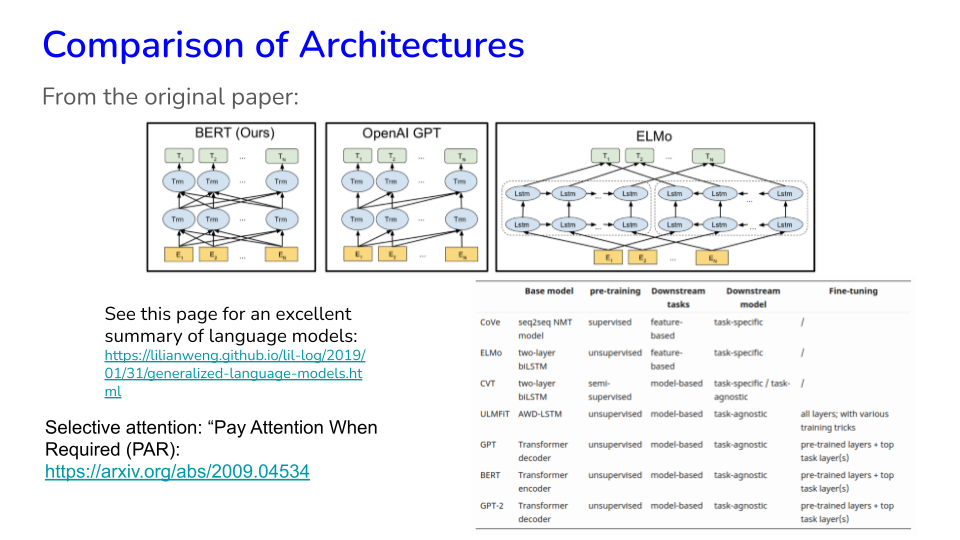

In [ ]:
Image("NLP_images/BERT (25).png", width=900)

## Transformers -- Other Useful Links

- Video on transformers: https://www.youtube.com/watch?v=bCz4OMemCcA

- 3Blue1Brown: https://www.youtube.com/watch?v=wjZofJX0v4M (Transformers); https://www.youtube.com/watch?v=eMlx5fFNoYc (Attention)

- Build a transformer from scratch: https://medium.com/towards-data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb

- Detailed view of transformers: https://e2eml.school/transformers.html

- Understanding and coding attention: https://drive.google.com/file/d/1wzQ8q0gno23v8zoyP6_lCsa-DXg5xbqS/view?usp=sharing

- Attnetion in Transformers: Concepts and Code in PyTorch (from DeepLearning.ai: https://learn.deeplearning.ai/courses/attention-in-transformers-concepts-and-code-in-pytorch/

## BERT (Summary)

1. BERT piggybacks on Transformer models, for a technical overview, see: https://drive.google.com/file/d/1G4tEu0SQrYglVIvgRqY17Khlbhvuf-4s/view?usp=sharing

2. BERT handles context better than word embeddings. Therefore it takes care of *polysemy*, i.e., same word meaning different things in different context.

3. BERT is trained using a denoising objective (masked language modeling), where it aims to reconstruct a noisy version of a sentence back into its original version. The concept is similar to autoencoders.

4. The original BERT uses a next-sentence prediction objective, but it was shown in the [RoBERTa paper](https://arxiv.org/abs/1907.11692) that this training objective doesn’t help that much. In this way, BERT is trained on gigabytes of data from various sources (much of Wikipedia) in an unsupervised fashion.

5. Google Research and Toyota Technological Institute jointly released a much smaller/smarter Lite Bert called ALBERT. (“ALBERT: A Lite BERT for Self-supervised Learning of Language Representations”). BERT x-large has 1.27 Billion parameters, vs ALBERT x-large with 59 Million parameters! The core architecture of ALBERT is BERT-like in that it uses a transformer encoder architecture, along with GELU activation. It also uses the identical vocabulary size of 30K as used in the original BERT. (V=30,000).

6. The downside of BERT is compute: you definitely need a GPU.

Will Transformers take over everything in NLP and computer vision? https://www.quantamagazine.org/will-transformers-take-over-artificial-intelligence-20220310/

## BERT with transfer learning

BERT input has a special structure. Take the sequence of words - "The paycheck protection program" and it gets encoded as

CLS | The | paycheck | protection | program | SEP | PAD | PAD | PAD

There are 3 vectors that are generated by this:

(1) Token IDs: these are integers that refer to the vocab index. Some have fixed IDs such as

- CLS = 101 (start id)
- UNK = 100 (unknown id)
- SEP = 102 (end/separator id)
- PAD = 0 (padding slots id)

The actual words get their ids from the vocab.

(2) Mask = 1 from CLS through SEP, 0 thereafter. It delineates the text from its padding.

(3) Segment = 1 for SEP, zero elsewhere. It delineates sentences.

Steps:

- tokenize + transform + create embedding

- See the first element of the embedding that is generated, it is what is passed to the NN.

In [ ]:
# Just trying out original BERT
txt = "love the show"
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
input_ids = array(tokenizer.encode(txt))[None,:]

## Use language model to return hidden layer with embeddings
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
embedding = nlp(input_ids)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
print("Structure of BERT input (size of text + 2):", input_ids)
print("Length of embedding structure:", len(embedding))
print("Shape of first element of embedding:", embedding[0][0].shape)  # size of input ids, BERT input vector size
print("Shape of second element of embedding:", embedding[1][0].shape)  #

Structure of BERT input (size of text + 2): [[ 101 2293 1996 2265  102]]
Length of embedding structure: 2
Shape of first element of embedding: (5, 768)
Shape of second element of embedding: (768,)


## Use distill BERT from Hugging Face

https://huggingface.co/docs/transformers/index

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
input_ids = array(tokenizer.encode(txt))[None,:]

## Use language model to return hidden layer with embeddings
nlp = transformers.TFBertModel.from_pretrained('distilbert-base-uncased')
embedding = nlp(input_ids)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.5.attention.q_lin.bias', 'distilbert.transformer.layer.2.sa_layer_norm.weight', 'distilbert.transformer.layer.1.sa_layer_norm.bias', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.5.attention.q_lin.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'distilbert.transformer.layer.3.output_layer_norm.weight', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.embeddings.word_embeddings.weight', 'distilbert.transformer.layer.4.attention.out_lin.weight', 'distilbert.transformer.layer.2.ffn.lin1.weight', 'distilbert.transformer.layer.3.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias

In [ ]:
print("Structure of BERT input (size of text + 2):", input_ids)
print("Length of embedding structure:", len(embedding))
print("   Shape of first element of embedding:", embedding[0][0].shape)  # size of input ids, BERT input vector size
print("   Shape of second element of embedding:", embedding[1][0].shape)  #

Structure of BERT input (size of text + 2): [[ 101 2293 1996 2265  102]]
Length of embedding structure: 2
   Shape of first element of embedding: (5, 768)
   Shape of second element of embedding: (768,)


In [ ]:
# Reuse the data from the TFIDF classification problem
corpus = df_train["Text"] # use Text not cleanTxt as we want context and need to keep the sentences as they are
len(corpus)

1811

In [ ]:
## Prepare BERT input for the training dataset
max_seq_length = 160  # The longest sentences in the dataset are less than this, adjust as needed

# Create a string of BERT and word tokens
corpus_tokenized = ["[CLS] "+" ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '',
                    str(txt).lower().strip()))[:max_seq_length])+" [SEP] " for txt in corpus]

## 1. Generate index values for the tokens and add padding, then make sure tokens are at max sequence length
txt2seq = [txt + " [PAD]"*(10+max_seq_length-len(txt.split(" "))) for txt in corpus_tokenized] # added 10 for extra padding (hack)
idx = [tokenizer.encode(seq)[1:-1][:max_seq_length] for seq in txt2seq]  # Need to drop the first and last element, and set no of token to max_seq_len

## 2. Generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(max_seq_length - len( txt.split(" "))) for txt in corpus_tokenized]

## 3. Generate segments
segments = []
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
            i += 1
    segments.append(temp)

# Finally, put all 3 elements into a feature matrix
X_train = [asarray(idx, dtype='int32'),
           asarray(masks, dtype='int32'),
           asarray(segments, dtype='int32')]

In [ ]:
# X_train is a 3 dimension tensor
print(len(X_train))  # one each for Token ID, Mask, Segment arrays
print(len(X_train[0])) # Size of the training set
print(len(X_train[0][0])) # max sequence length + 2 (for CLS and SEP)

3
1811
160


In [ ]:
df_train

Text     Label  \
1633  Finnish silicon wafer technology company Okmet...   neutral   
1909  The real estate company posted a net loss of +...  negative   
1534         The value of the orders is about EUR 70mn    neutral   
2037  Operating profit excluding non-recurring items...  negative   
1276  Its market share is 6 percent according to AC ...   neutral   
...                                                 ...       ...   
1650  In addition , the Kazakh delegation will visit...   neutral   
2057  efficiency improvement measures 20 January 201...  positive   
1126  Work on the assignment has already started and...   neutral   
2228  The announcement pushed Freenet shares down 6....  negative   
1066  The cranes would be installed onboard two frei...   neutral   

                                               cleanTxt  
1633  finnish silicon wafer technology company okmet...  
1909  real estate company posted net loss ó x ¼ mill...  
1534                                 value order eur mn  
2037  operating profit excluding nonrecurring item e...  
1276     market share percent according ac nielsen data  
...                                                 ...  
1650  addition kazakh delegation visit finland sitra...  
2057  efficiency improvement measure january finnish...  
1126  work assignment already started due completion...  
2228  announcement pushed freenet share eur frankfur...  
1066  crane would installed onboard two freighter or...  

[1811 rows x 3 columns]

In [ ]:
k = randint(len(X_train[0])) # Pick a random sentence, try 302
# print(df_train["Text"][k])
print(len(X_train[0][k]))
print(X_train[0][k])   # Token ids
print(X_train[1][k])   # mask
print(X_train[2][k])   # segment

160
[  101  6503  1997  1996 12598  2003  3395  2000  1037  2345  3820  1998
  1037  2349 29454  1001  1001  1045  6914  1001  1001  8292  2832   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 

## Fine-Tuning

We are using DistilBERT below, which only requires the token IDs and masks (not segments).

In [ ]:
# Build up model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import transformers
import numpy as np

## inputs
idx = layers.Input((max_seq_length,), dtype="int32", name="input_idx")
masks = layers.Input((max_seq_length,), dtype="int32", name="input_masks")
segments = layers.Input((max_seq_length,), dtype="int32", name="input_segments")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Wrap the DistilBERT call in a Lambda layer and specify output_shape
bert_out = layers.Lambda(
    lambda x: nlp(x[0], attention_mask=x[1])[0],
    output_shape=(max_seq_length, nlp.config.hidden_size)  # Add output_shape
)([idx, masks])

## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)),activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_idx (InputLayer)    │ (None, 160)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_masks (InputLayer)  │ (None, 160)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 160, 768)       │              0 │ input_idx[0][0],       │
│                           │                        │                │ input_masks[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 768)            │              0 │ lambda[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         49,216 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 3)              │            195 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,411 (193.01 KB)

 Trainable params: 49,411 (193.01 KB)

 Non-trainable params: 0 (0.00 B)

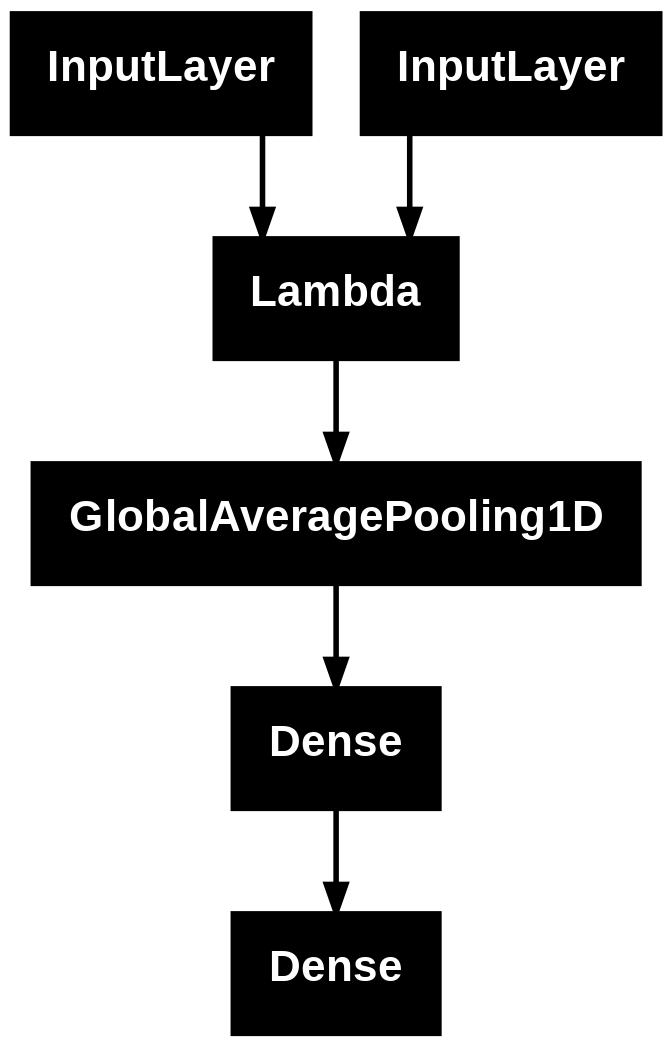

In [ ]:
plot_model(model)  # option to_file=

In [ ]:
# Create label y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [ ]:
print(len(X_train[1]))
print(unique(y_train))

1811
[0 1 2]


In [ ]:
%%time
## train
training = model.fit(x=X_train[:2], y=y_train, batch_size=32, epochs=10, shuffle=True, verbose=1, validation_split=0.3)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 365ms/step - accuracy: 0.6249 - loss: 0.8365 - val_accuracy: 0.7390 - val_loss: 0.5573
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.7858 - loss: 0.5044 - val_accuracy: 0.7629 - val_loss: 0.5094
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8241 - loss: 0.4307 - val_accuracy: 0.7996 - val_loss: 0.4640
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.8418 - loss: 0.4082 - val_accuracy: 0.8033 - val_loss: 0.4538
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.8636 - loss: 0.3511 - val_accuracy: 0.7849 - val_loss: 0.4483
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.8799 - loss: 0.3064 - val_accuracy: 0.8162 - val_loss: 0.4423
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.8779 - loss: 0.3196 - val_accuracy: 0.8143 - val_loss: 0.4234
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.9007 - loss: 0.2749 - val_accurac

In [ ]:
# INPUT STRUCTURE FOR TEST DATASET
corpus = df_test["Text"]

# Create a string of BERT and word tokens
corpus_tokenized = ["[CLS] "+" ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '',
                    str(txt).lower().strip()))[:max_seq_length])+" [SEP] " for txt in corpus]

## 1. Generate index values for the tokens and add padding, then make sure tokens are at max sequence length
txt2seq = [txt + " [PAD]"*(10+max_seq_length-len(txt.split(" "))) for txt in corpus_tokenized] # added 10 for extra padding (hack)
idx = [tokenizer.encode(seq)[1:-1][:max_seq_length] for seq in txt2seq]  # Need to drop the first and last element, and set no of token to max_seq_len

## 2. Generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(max_seq_length - len( txt.split(" "))) for txt in corpus_tokenized]

## 3. Generate segments
segments = []
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
            i += 1
    segments.append(temp)

# Finally, put all 3 elements into a feature matrix
X_test = [asarray(idx, dtype='int32'),
           asarray(masks, dtype='int32'),
           asarray(segments, dtype='int32')]

In [ ]:
## test labels
predicted_prob = model.predict(X_test[:2])
dic_y_mapping = {0:'neutral', 1:'negative', 2:'positive'}  # for the financial phrase bank dataset
predicted = [dic_y_mapping[argmax(pred)] for pred in predicted_prob]

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step


In [ ]:
tmp = zeros(len(predicted))
for j in range(len(tmp)):
    if predicted[j]=='negative':
        tmp[j] = 1
    elif predicted[j]=='positive':
        tmp[j] = 2
predicted = tmp

accuracy = metrics.accuracy_score(y_test, predicted)
# auc = metrics.roc_auc_score(y_test, predicted_prob[:,1])  # only for binary classification
print("Accuracy:", round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
cm = metrics.confusion_matrix(y_test, predicted)
print(cm)

Accuracy: 0.86
Detail:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       273
         1.0       0.73      0.55      0.63        58
         2.0       0.74      0.82      0.78       122

    accuracy                           0.86       453
   macro avg       0.80      0.77      0.78       453
weighted avg       0.86      0.86      0.85       453

[[256   2  15]
 [  5  32  21]
 [ 12  10 100]]


- TFIDF accuracy = 80-85%
- Word2Vec accuracy = 70-75%
- BERT accuracy = 82-89%

## REFERENCES

1. https://towardsdatascience.com/a-no-frills-guide-to-most-natural-language-processing-models-the-transformer-xl-era-ff5035f04e0f

2. Using BERT for the first time (by J Alammar): http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/; code: https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

3. Stanford Sentiment Treebank: https://nlp.stanford.edu/sentiment/index.html

## From the reference above, using the SST dataset (movie reviews)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_large = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
print(df_large.shape)
df_large.head()

(6920, 2)


0  1
0  a stirring , funny and finally transporting re...  1
1  apparently reassembled from the cutting room f...  0
2  they presume their audience wo n't sit still f...  0
3  this is a visually stunning rumination on love...  1
4  jonathan parker 's bartleby should have been t...  1

In [ ]:
# Is the dataset balanced in labels?
df = df_large[:1500]  # take a small subset
df[1].value_counts()

1
1    782
0    718
Name: count, dtype: int64

## Get the pre-trained model

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# Get tokenized version
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized.shape)
tokenized[0]

(1500,)


[101,
 1037,
 18385,
 1010,
 6057,
 1998,
 2633,
 18276,
 2128,
 16603,
 1997,
 5053,
 1998,
 1996,
 6841,
 1998,
 5687,
 5469,
 3152,
 102]

## Construct token IDs and masks

In [ ]:
# Add padding and set max len to the longest entry in the dataset
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(array(padded).shape)
padded[:3]

(1500, 59)


array([[  101,  1037, 18385,  1010,  6057,  1998,  2633, 18276,  2128,
        16603,  1997,  5053,  1998,  1996,  6841,  1998,  5687,  5469,
         3152,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [  101,  4593,  2128, 27241, 23931,  2013,  1996,  6276,  2282,
         2723,  1997,  2151,  2445, 12217,  7815,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [  101,  2027,  3653, 23545,  2037,  4378, 24185,  10

In [ ]:
# Add a mask to let BERT know where the real tokens are and not the padding
# Essentially we can use zero for the padding mask so those tokens do not compute
attention_mask = where(padded != 0, 1, 0)
print(attention_mask.shape)
attention_mask[:3]

(1500, 59)


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## Run token IDs and attention masks through BERT to get embeddings

In [ ]:
%%time
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)  #embeddings

CPU times: user 1min 18s, sys: 18.3 s, total: 1min 37s
Wall time: 1min 50s


In [ ]:
# Embeddings from BERT
print(len(last_hidden_states[0][:,0,:]))
last_hidden_states[0][:,0,:]

1500


tensor([[-0.2159, -0.1403,  0.0083,  ..., -0.1369,  0.5867,  0.2011],
        [-0.1726, -0.1448,  0.0022,  ..., -0.1744,  0.2139,  0.3720],
        [-0.0506,  0.0720, -0.0296,  ..., -0.0715,  0.7185,  0.2623],
        ...,
        [ 0.0062,  0.0426, -0.1080,  ..., -0.0417,  0.6836,  0.3451],
        [ 0.0087,  0.0605, -0.3309,  ..., -0.2005,  0.6268,  0.1546],
        [-0.2395, -0.1362,  0.0463,  ..., -0.0285,  0.2219,  0.3242]])

In [ ]:
# Collect the CLS embedding and labels to set up the classification task
features = last_hidden_states[0][:,0,:].numpy()
labels = df[1]
print(features.shape)

(1500, 768)


## Use the BERT transformed dataset for machine learning as usual

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.8266666666666667

## Speed

As you can see, BERT runs slow, so it is good to use a machine with GPUs. For more on computation speed, see: https://blog.inten.to/speeding-up-bert-5528e18bb4ea